## iCUPE data pilot - Anderma/Russia Mercury data visualization

This script is a demonstration of the iCUPE data pilot interoperability. 

### Usage
The pilot needs a Python 3.x notebook environment. It is set up to run inside a [Docker](https://www.docker.com) 
container environment that can be easily deployed on cloud computing systems. 
For the pilot's development the [Jupyter Docker Stacks](https://jupyter-docker-stacks.readthedocs.io/en/latest/) preconfigured
datascience notebook was used. As this one is based on the scipy-notebook, the code will also run there.

Once access to a docker system is avaiable enter the command:

    docker run -p 8888:8888 -v <path/to/notebook/directory>:/home/jovyan jupyter/datascience-notebook [start.sh jupyter lab]

The part in brackets at the end is optional and will start the Jupyterlab environment instead of the notebook environment.

### Data processing pipeline

The pilot first sets up additional libraries that are needed to complete the task and may not be in the preconfigured docker containers or in a local setup. 

1. Download the dataset file from iCUPE website to the notebook directory
2. Unpack the datafile to the notebook directory
3. Import the data into a dataframe
4. Create daily data frames from the hourly measurements and take care of missing values
5. Build yearly time series
6. Visualize yearly data

### Run the notebook

- In the notebook environment choose from menu [Cell] [Run all]
- In the Jupyter lab environment choose [Run] [Run all Cells]

***
Author: Steffen M. Noe (steffen.noe@emu.ee)

Contact:<br>
Institute of Forestry and Rural Engineering,<br>
Estonian University of Life Sciences,<br>
Kreutzwaldi 1, EE-51006, Tartu, Estonia
        
© Author(s) 2021. This work is distributed under<br> 
the Creative Commons Attribution 4.0 License.

<img src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by.png" width="84"></img>
       
***

In [1]:
# Install wget for access to web hosted files via pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install wget

  Using cached wget-3.2-py3-none-any.whl


In [2]:
# Constants used for the Jupyter Docker Stack notebooks to be run containerized!
# You may need to replace in case the notebook is run on a local jupyter server!

HOMEDIR = '/home/jovyan/' # Replace for local usage
FILENAM = 'DS_Hg-Amderma_20200125.zip'
XLSFILE = 'DS_Hg-Amderma_20200125.xlsx'

In [3]:
# Load dataset from server and store it to the container or local file system
#
import wget
import os.path

if not os.path.isfile(FILENAM):
    url = 'https://www.atm.helsinki.fi/icupe/images/Datasets/DS_Hg-Amderma_20200125.zip'
    wget.download(url, HOMEDIR+FILENAM)

In [4]:
import zipfile

if not os.path.isfile(XLSFILE):
    with zipfile.ZipFile(HOMEDIR+FILENAM, 'r') as zip_ref:
        zip_ref.extractall(HOMEDIR)

In [5]:
# install a newer version for xlsx support
!{sys.executable} -m pip install openpyxl

     |████████████████████████████████| 243 kB 4.0 MB/s eta 0:00:01
  Using cached et_xmlfile-1.0.1-py3-none-any.whl


In [6]:
# Load essential libraries for data handling, date-time operations and numerical calculations
# and plotting routines
#
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# read in the info from the xlsx file to obtain the sheet names
xls = pd.ExcelFile(XLSFILE)

# store number of sheets for convenice
noofsheets = len(xls.sheet_names)

# create a list of dataframes with the sheets
dfs = []
for i in xls.sheet_names:
    dfs.append(xls.parse(i))

In [8]:
def makeDailyDataFrame(df, count=0):
    '''
    Make a dataframe where the first column is the timestamp and thesecond 
    column the measured mercury concentration.
    
    Parameters: 
    df    - a dataframe
    count - the data has different counts per year from the Excel import and
            a column identifier is needed to be created accordingly
    
    Returns:
    a dataframe with:
        datim - a datetime object that holds the timestamp
        Hg    - the measured mercury concentration    
    '''
    
    # Create an column identifier key that fits to the data from the Excel file.
    if count > 0:
        dateId = 'Date' + '.' + str(count)
        timeId = 'Time (LST)' + '.' + str(count)
        mercId = 'Hg (ng/m3)' + '.' + str(count)
    else:
        dateId = 'Date' 
        timeId = 'Time (LST)'
        mercId = 'Hg (ng/m3)' 
            
    # Get the length of the dataframe to be processed, read out the day
    # and the time. 
    # CAUTION: the first entry of time is sometimes a datetime object and only the 
    # time is needed. If its already a datetime.time object the value can taken over.
    #
    n = len(df)
    date = df[dateId].iloc[0].date()
    
    try:
        time = df[timeId].iloc[0].time()
    except AttributeError:
        time = df[timeId].iloc[0]
        
    # Create a new dataframe object with the first row from the input df
    #
    if time != np.NaN:    
        ndf = pd.DataFrame({
                "datim": [dt.datetime.combine(date, time)],
                "Hg"   : [df[mercId].iloc[0]]
                },
                columns = ["datim", "Hg"])
    
    
        # Loop over the rest of the input df and append the data to ndf.
        # CAUTION: the subsequent time data are already datetime.time objects
        # and no conversion is needed.
        #
        for i in range(1,n):
            time = df[timeId].iloc[i]
            
            # Test if the time is a time object or a datetime object
            # Ensure it's a time object
            #
            if isinstance(time, dt.datetime):
                time = time.time()
            
            # The data contain NaN entries in some time fields, these are ignored.
            #
            if isinstance(time, dt.time):
                ndf = ndf.append(pd.DataFrame({
                    "datim": [dt.datetime.combine(date, time)],
                    "Hg"   : [df[mercId].iloc[i]]
                    },
                    columns = ["datim", "Hg"]),
                    ignore_index = True
                )
            else:
                pass

    return ndf

In [9]:
def processYear(df, key=0):
    '''
    Process the data per year as given by the Excel data sheets. Years 2001 - 2004 are in df[0], 
    years 2005 - 2010 first half year are in df[1] and years 2010 second half - 2013 are in df[2].
    
    Parameters:
    df  - input dataframe
    key - numerical key that is used to compile the dataframe column key
    
    Returns:
    a dataframe with:
        datim - a datetime object that holds the timestamp
        Hg    - the measured mercury concentration   
    '''
    
    # Choose key values by identifier
    if key > 0:
        dateId = 'Date' + '.' + str(key)
        timeId = 'Time (LST)' + '.' + str(key)
        mercId = 'Hg (ng/m3)' + '.' + str(key)
    else:
        dateId = 'Date' 
        timeId = 'Time (LST)'
        mercId = 'Hg (ng/m3)'     
    
    #print(dateId, " : ", timeId, " : ", mercId)
    
    # Create index by filter the NaN and NaT elemets out from date and time
    #
    dfDate = df[[dateId]]
    idx = dfDate.index[dfDate[dateId].notnull()].tolist()
    #print(dfDate.head())
    #print(idx)
    
    # Create raw dataframe for processing 
    
    rawDf = df.iloc[:idx[-1]+24][[dateId, timeId, mercId]]
    #print(rawDf)
    
    # Create an empty dataframe
    #
    dfy = pd.DataFrame()
    
    # Loop over the index and merge the daily dataframes
    #
    for i in range(len(idx)-1):
        dfy = dfy.append(makeDailyDataFrame(rawDf[idx[i]:idx[i+1]], key), ignore_index = True)
    
    # Merge the last day data into the yearly dataframe
    #
    dfy = dfy.append(makeDailyDataFrame(rawDf[idx[-1]:], key), ignore_index = True)
    
    return dfy

In [10]:
# Function to visualise the data per year on a daily basis using box-whisker charts.
# The outliers have been omitted for a clearer overview.
#
def visualizeDay(df, ntick):
    '''
    Visualize daily data by combining the hourly values into daily datasets and use a box-whisker chart
    to present the median, lower and upper quantils (.25, .75) and whiskers min and max of the dataset.
    It also compiles some added metadata like location, year of the dataset, data coverage.
    
    Parameters:
    df    - input dataframe
    ntick - number of tick marks and tiks to be shown
    
    Returns:
    nothing
    '''
    
    # Calculate some Metadata from the input data
    #
    year = pd.to_datetime(df.datim.values[0]).year
    days = round(len(df.dropna())/24, 2)
    perc = round(days/356 * 100, 2)
    
    # Create the plot, select days from dataframe
    #
    ax = df.groupby(pd.Grouper(key='datim',freq='D')).boxplot(subplots=False, figsize=(20,7), rot=90, showfliers=False)
    
    # Retrieve the ticks and tick labels from the plot
    #
    ticks = ax.get_xticks()
    labels = ax.get_xticklabels()
    
    # Reduce the number of shown tick and labels from one per box to ntick.
    # Also the long annotation as datetime object gets shortened to YYYY-MM-DD format.
    #
    n = len(ticks) // ntick  # Show n ticks only.
    for a in labels[::n]:
        t = a.get_text()[1:11]
        a.set_text(t)
    ax.set_xticks(ticks[::n])
    ax.set_xticklabels(labels[::n])
    
    ax.set_ylabel('Hg (ng m$^-3$)')
    
    # Set the Metadata as plot title
    #
    ax.set_title('iCUPE DATASET ANDERMA (lat: 69.46, lon: 61.41, asl: 49 m ) - ' + str(year) + ' - DATACOVERAGE: ' + str(perc)\
                 + '%, ' + str(days) + ' out of 365 days'                  
                )
    plt.show()

In [11]:
# Create a list off all years data 2001 == idx 0 .. 2012 == idx 11
#
print('Be patient...')
dfys = []
dfys.append(processYear(dfs[0]))      # 2001
dfys.append(processYear(dfs[0], 1))   # 2002
dfys.append(processYear(dfs[0], 2))   # 2003
dfys.append(processYear(dfs[0], 3))   # 2004
dfys.append(processYear(dfs[1]))      # 2005
dfys.append(processYear(dfs[1], 1))   # 2006
dfys.append(processYear(dfs[1], 2))   # 2007
dfys.append(processYear(dfs[1], 3))   # 2008
dfys.append(processYear(dfs[1], 4))   # 2009
df101 = processYear(dfs[1], 5)                         # part 1 of 2010
df101.append(processYear(dfs[2]), ignore_index = True) # append part 2 of 2010
dfys.append(df101)                    # 2010
dfys.append(processYear(dfs[2], 1))   # 2011
dfys.append(processYear(dfs[2], 2))   # 2012
print('well done')


Be patient...
well done


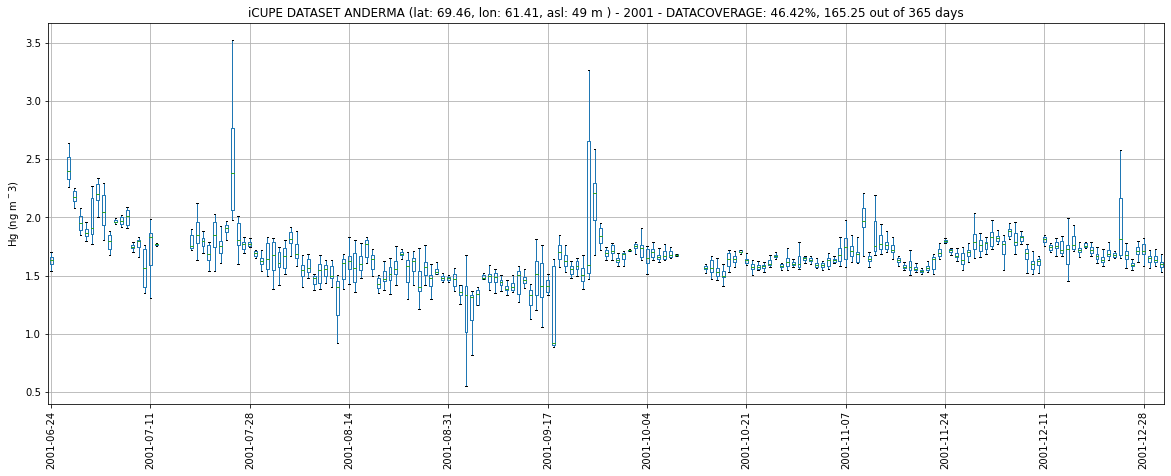

In [12]:
visualizeDay(dfys[0].dropna(),11)

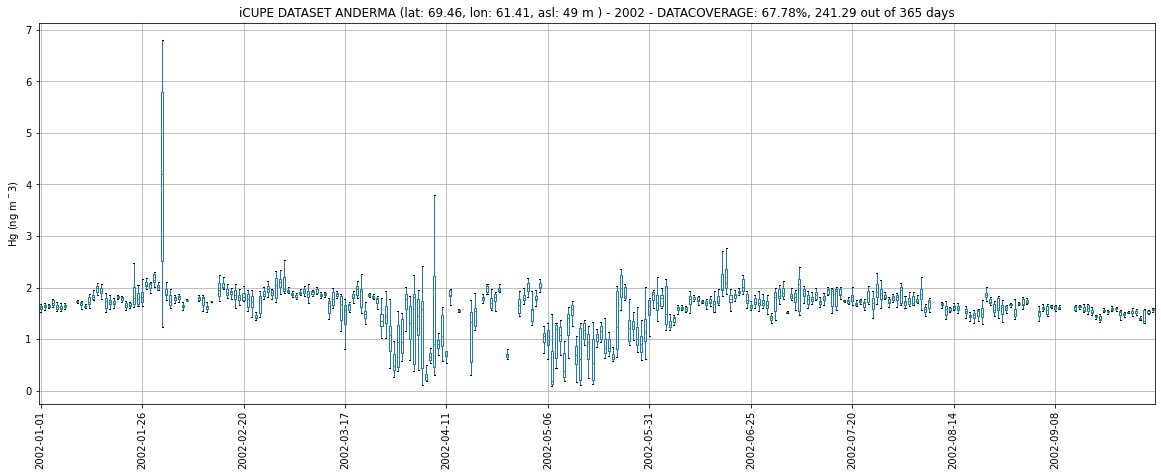

In [13]:
visualizeDay(dfys[1].dropna(),11)

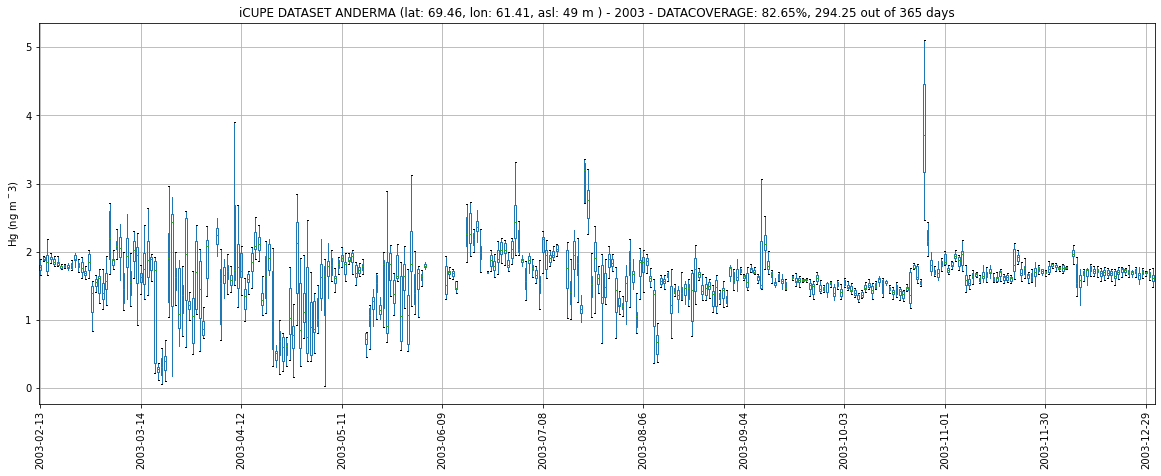

In [14]:
visualizeDay(dfys[2].dropna(),11)

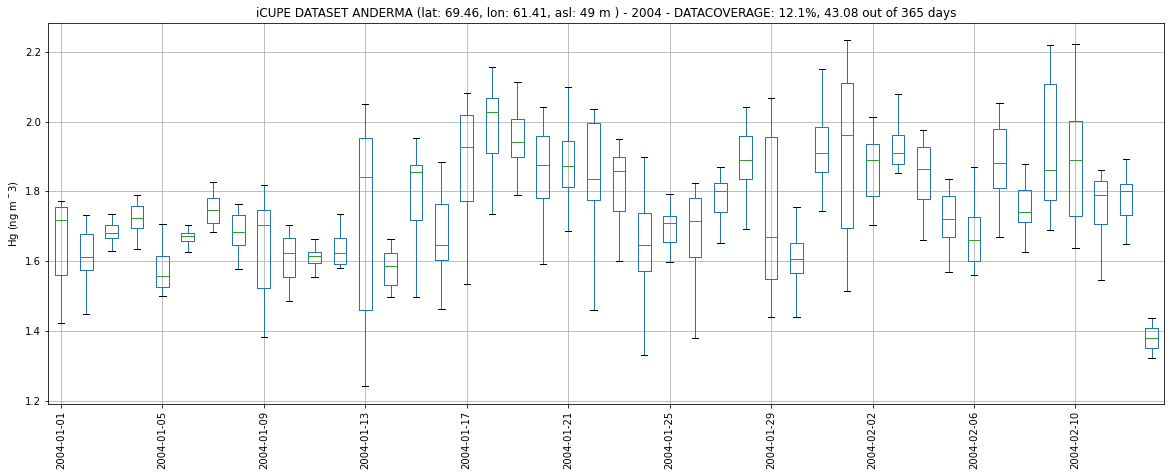

In [15]:
visualizeDay(dfys[3].dropna(),11)

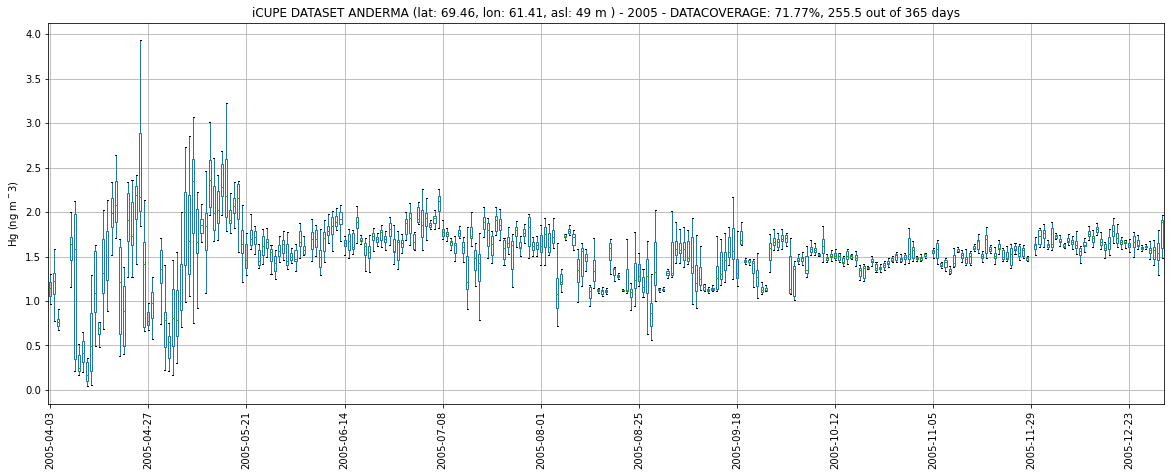

In [16]:
visualizeDay(dfys[4].dropna(),11)

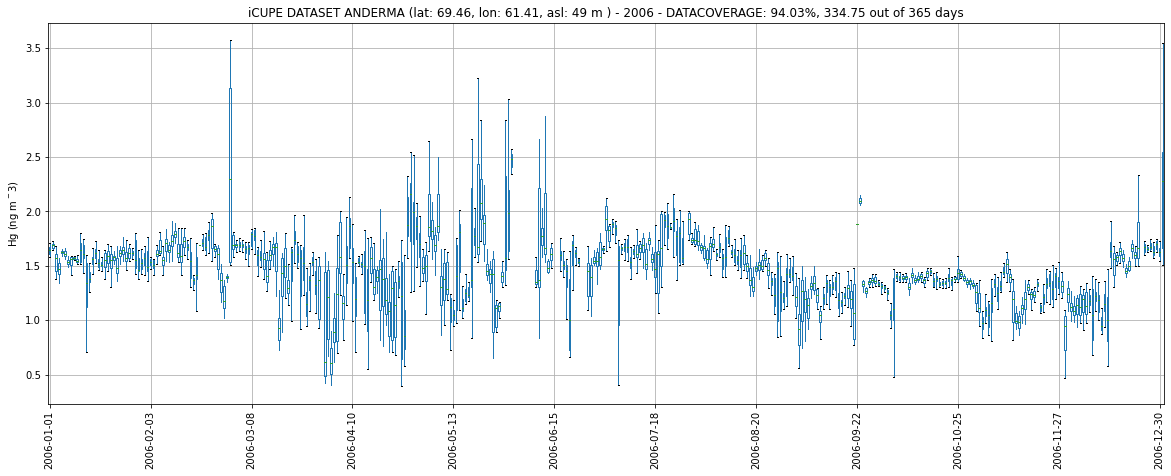

In [17]:
visualizeDay(dfys[5].dropna(),11)

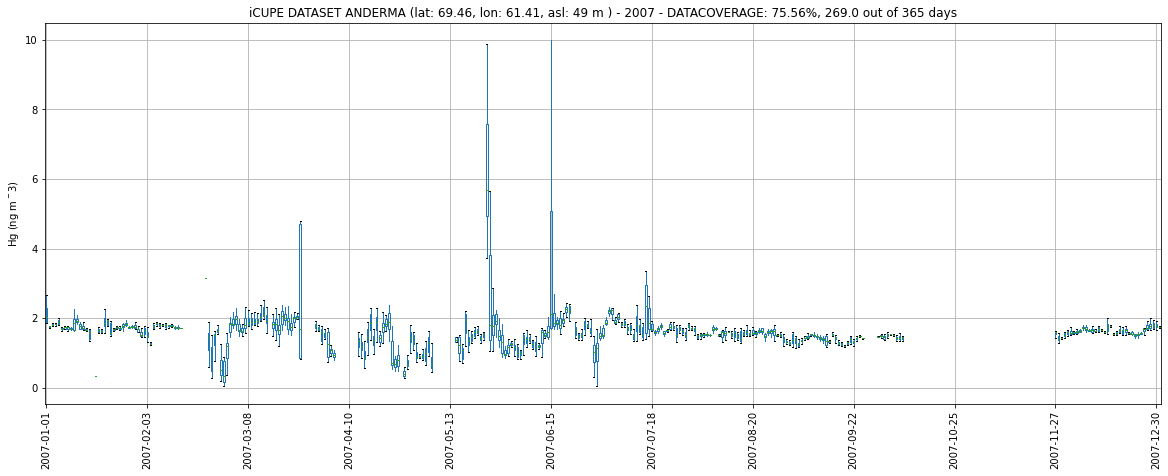

In [18]:
visualizeDay(dfys[6].dropna(),11)

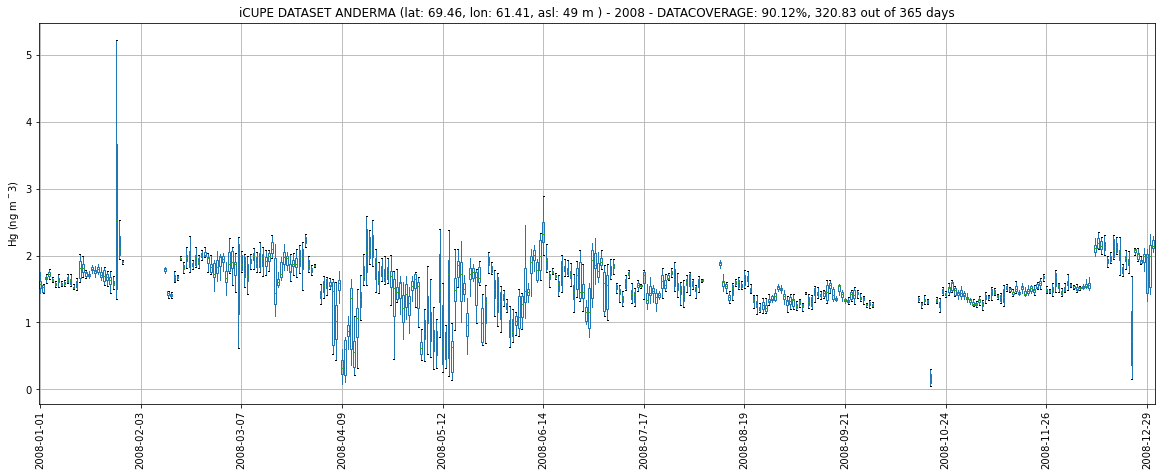

In [19]:
visualizeDay(dfys[7].dropna(),11)

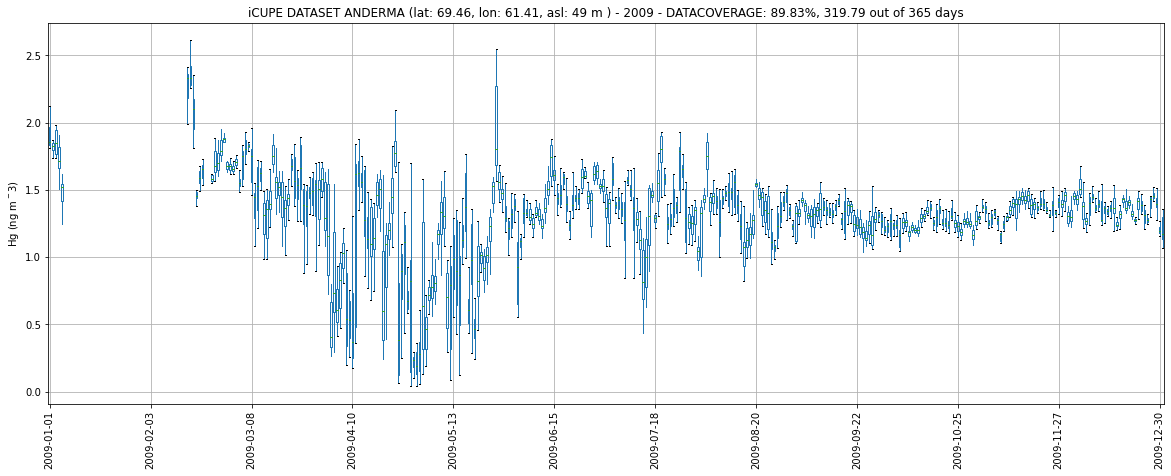

In [20]:
visualizeDay(dfys[8].dropna(),11)

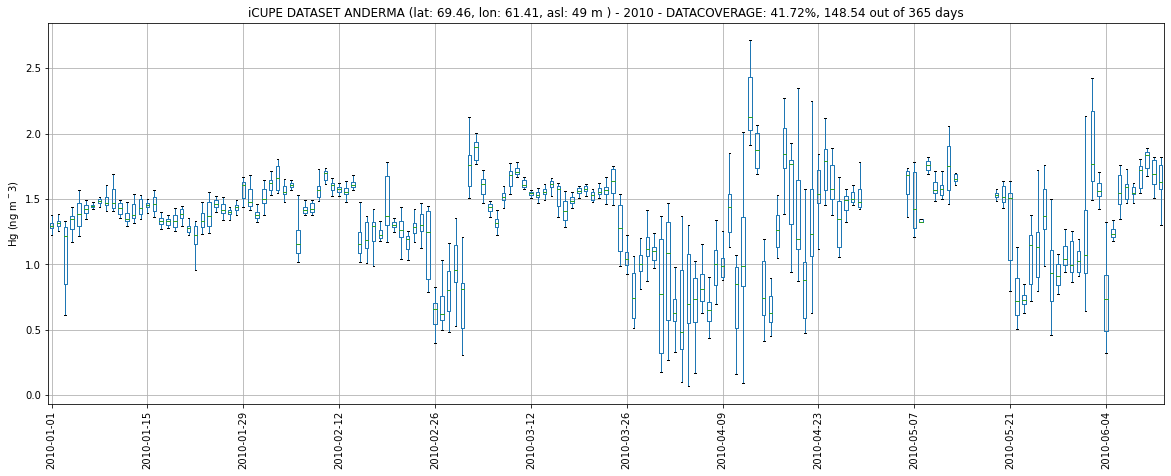

In [21]:
visualizeDay(dfys[9].dropna(),11)

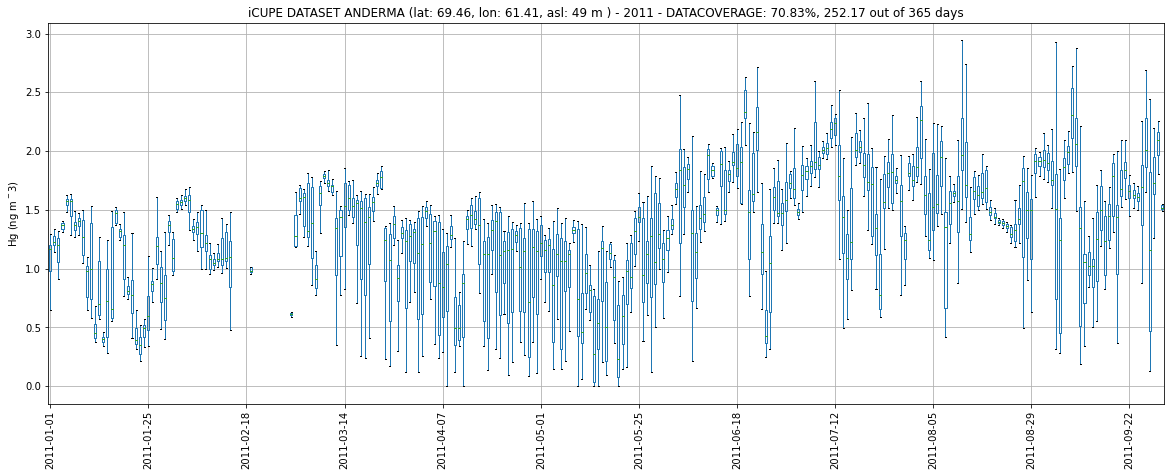

In [22]:
visualizeDay(dfys[10].dropna(),11)

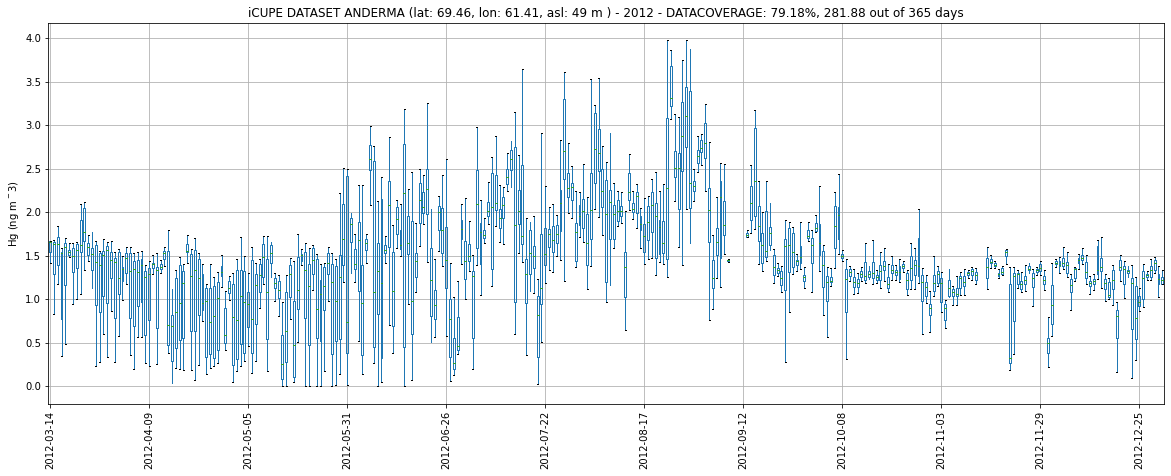

In [23]:
visualizeDay(dfys[11].dropna(),11)